# Assignment 5

Suggested due date : 7th November 2018

## Policy gradients on Cartpole with OpenAI Gym

The aims for this assignment are:
* Get familiar with the Cartpole environment in OpenAI Gym.
* Implement REINFORCE and actor-critic policy gradient algorithms in TensorFlow.

## The Cartpole environment

Cartpole is a classic simulated control environment, first described by Sutton and Barto, with a continuous state space and discrete action space.
The task consists in maintaining a pole in a vertical position by moving a cart on which the pole is attached with a joint. No friction is considered. The task is considered solved if the pole stays upright (within 15 degrees) for 195 steps on average, over 100 episodes, while keeping the cart position within reasonable bounds.
The state is 4 scalars - position and angle of the cart with the vertical, as well as the time derivatives of these quantities - but the aim of our RL algorithms is to solve the task without that knowledge. There are only two possible actions : left, and right. See <a href="https://gym.openai.com/envs/CartPole-v0/" /> the Gym documentation </a> for more details.

## Policy gradient methods

Policy gradient methods (see slides from RL lecture 2) have a tendency to scale better on large state spaces, which is of interest here, since CartPole is a continuous state space environment.
The policy gradient theorem helps us do away with knowing the dynamics of the system, and building a stochastic gradient estimate just from one-step transitions. We will use it - and its special case REINFORCE - in order to solve our Cartpole problem.

To this end:

* Try the env.step(action) method with a constant policy, in order to get familiar with the environment.
* Implement a sigmoid policy that selects the right action with probability 
<a href="http://www.codecogs.com/eqnedit.php?latex=\sigma(\theta^t&space;s),&space;\quad&space;\sigma(x):=\frac{1}{1&plus;e^{-x}}" target="_blank"><img src="http://latex.codecogs.com/gif.latex?\sigma(\theta^T&space;s),&space;\quad&space;\sigma(x):=\frac{1}{1&plus;e^{-x}}" title="\sigma(\theta^t s), \quad \sigma(x):=\frac{1}{1+e^{-x}}" /></a> , with theta the parameter vector and s the state vector. Then evaluate its performance by averaging over 100 episodes.
* Compute analytically the gradient w.r.t parameters of the log-policy (for each action) - on paper and in closed form.
* Implement REINFORCE by running rollouts with current policy. Use a fixed, maximal horizon of 250 steps. Loop the computation of the policy gradient, the parameter update via gradient ascent, and the check of whether the new policy has an average return >=195. 
* Bonus : reduce gradient variance, either by using a Monte-Carlo estimate of the average return, or using a parametric value function to estimate average returns as a baseline.
* Bonus 2 : implement a softmax policy instead of our sigmoid above ; move all the code to TensorFlow to use full neural network approximation and the standard backpropagation tools.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.distributions as dist

import gym

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [2]:
env = gym.make("CartPole-v0")
print(env.observation_space, env.action_space)

Box(4,) Discrete(2)


In [3]:
# Policy model

class Policy(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            nn.Softmax(1)
        )
    
    def forward(self, x):
        return self.model(x)

In [4]:
policy = Policy()

optim = torch.optim.Adam(policy.parameters(), lr=1e-3)
losses = []
steps = []

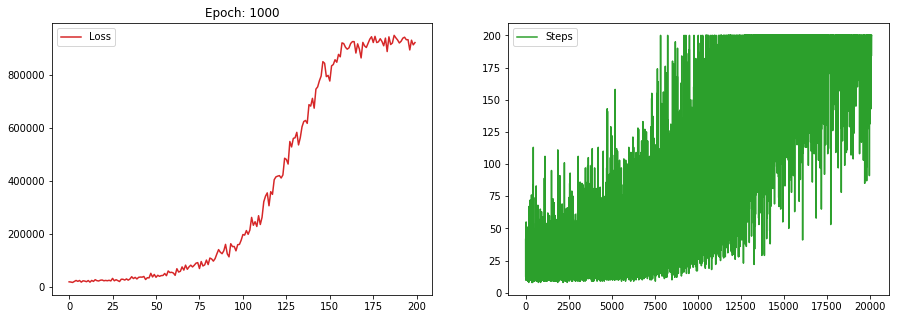

In [12]:
# Monte Carlo REINFORCE
epochs = 1000
episodes = 100

gamma = 0.999

for epoch in range(epochs):
    loss = 0
    optim.zero_grad()

    for ep in range(episodes):
        states = []
        actions = []
        rewards = []
    
        s = env.reset()
        done = False
        with torch.no_grad():
            while not done:
                a = policy(torch.tensor(s, dtype=torch.float).unsqueeze(0)).squeeze()
                
                a = dist.categorical.Categorical(a).sample()
                a = int(a)
            
                states.append(s)
                actions.append(a)
        
                s, r, done, _ = env.step(a)

                rewards.append(r)
    
        q_acc = 0
        
        for t in range(len(states)-1, 0, -1):
            q_acc = gamma * q_acc + rewards[t]
        
            pred = policy(torch.tensor(states[t-1], dtype=torch.float).unsqueeze(0)).squeeze()
        
            loss = loss - q_acc * torch.log(pred[actions[t-1]])   
    
        steps.append(len(states))
    
    losses.append(loss.item())
    loss.backward()
    optim.step()
    
    clear_output(wait=True)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(losses, label="Loss", color="tab:red")
    ax[0].set_title("Epoch: {}".format(epoch))
    ax[0].legend()
    ax[1].plot(steps, label="Steps", color="tab:green")
    ax[1].legend()
    plt.show()

In [23]:
# View the cart-pole in action
s = env.reset()
done = False
steps = 0
with torch.no_grad():
    while not done:
        steps += 1
        env.render()
        a = policy(torch.tensor(s, dtype=torch.float).unsqueeze(0)).squeeze()
                
        a = dist.categorical.Categorical(a).sample()
        a = int(a)
        
        s, _, done, _ = env.step(a)
print("Steps: ", steps)

Steps:  200


In [27]:
# Compute average steps over 100 plays
steps = []
for i in range(100):
    s = env.reset()
    done = False
    st = 0
    with torch.no_grad():
        while not done:
            st += 1
            env.render()
            a = policy(torch.tensor(s, dtype=torch.float).unsqueeze(0)).squeeze()
                
            a = dist.categorical.Categorical(a).sample()
            a = int(a)
        
            s, _, done, _ = env.step(a)
    steps.append(st)
print("average steps: ", sum(steps)/len(steps))

average steps:  197.81
